In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
# Mount the google drive containing data taken from kaggle (https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/F1-data-analysis'
qualifying = pd.read_csv(f'{file_path}/qualifying.csv')
races = pd.read_csv(f'{file_path}/races.csv')

In [ ]:
# Aim: To look at the qualifying times for the tracks that have been in all seasons since 1990. Plot them as a distribution,
# Adding the season ID to the driver standings data
qualifying = qualifying.merge(races[['raceId','year']], on='raceId')

In [ ]:
qualifying.head()

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,year
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714,2008
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869,2008
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079,2008
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178,2008
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236,2008


In [ ]:
def time_to_seconds(time_str):
  try:
    minutes, seconds = map(float, str(time_str).split(':'))
    return minutes * 60 + seconds
  except ValueError:
    return None


print(qualifying.dtypes)
qualifying['q1'] = qualifying['q1'].apply(time_to_seconds)
qualifying['q2'] = qualifying['q2'].apply(time_to_seconds)
qualifying['q3'] = qualifying['q3'].apply(time_to_seconds)


fastest_q1_time = qualifying.groupby(['year','raceId'])['q1'].min().reset_index()
fastest_q1_time.rename(columns={'q1': 'fastest_q1_time'}, inplace=True)
fastest_q2_time = qualifying.groupby(['year','raceId'])['q2'].min().reset_index()
fastest_q2_time.rename(columns={'q2': 'fastest_q2_time'}, inplace=True)
fastest_q3_time = qualifying.groupby(['year','raceId'])['q3'].min().reset_index()
fastest_q3_time.rename(columns={'q3': 'fastest_q3_time'}, inplace=True)


# Merge the fastest_q1_time back into the original DataFrame
qualifying = qualifying.merge(fastest_q1_time, on=['year', 'raceId'], how='left')
qualifying = qualifying.merge(fastest_q2_time, on=['year', 'raceId'], how='left')
qualifying = qualifying.merge(fastest_q3_time, on=['year', 'raceId'], how='left')

# Calculate the time-split by subtracting the fastest q1 time
qualifying['time-split-q1'] = qualifying['q1'] - qualifying['fastest_q1_time']
qualifying['time-split-q2'] = qualifying['q2'] - qualifying['fastest_q2_time']
qualifying['time-split-q3'] = qualifying['q3'] - qualifying['fastest_q3_time']

qualifying.head()

qualifyId         int64
raceId            int64
driverId          int64
constructorId     int64
number            int64
position          int64
q1               object
q2               object
q3               object
year              int64
dtype: object


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,year,fastest_q1_time,fastest_q2_time,fastest_q3_time,time-split-q1,time-split-q2,time-split-q3
0,1,18,1,1,22,1,86.572,85.187,86.714,2008,85.664,85.187,86.714,0.908,0.000,0.000
1,2,18,9,2,4,2,86.103,85.315,86.869,2008,85.664,85.187,86.714,0.439,0.128,0.155
2,3,18,5,1,23,3,85.664,85.452,87.079,2008,85.664,85.187,86.714,0.000,0.265,0.365
3,4,18,13,6,2,4,85.994,85.691,87.178,2008,85.664,85.187,86.714,0.330,0.504,0.464
4,5,18,2,2,3,5,85.960,85.518,87.236,2008,85.664,85.187,86.714,0.296,0.331,0.522


In [ ]:
quali = qualifying[['raceId','driverId','time-split-q1','time-split-q2','time-split-q3','year']]
quali.head()

,raceId,driverId,time-split-q1,time-split-q2,time-split-q3,year
0,18,1,0.908,0.000,0.000,2008
1,18,9,0.439,0.128,0.155,2008
2,18,5,0.000,0.265,0.365,2008
3,18,13,0.330,0.504,0.464,2008
4,18,2,0.296,0.331,0.522,2008


In [ ]:
# Create a horizontal violin plot
import seaborn as sns
import matplotlib.pyplot as plt

def plot_time_split_violin(df, year):
    year_data = df[df['year'] == year]
    # Extract the time-split columns
    time_split_columns = ['time-split-q1', 'time-split-q2', 'time-split-q3']

    # Concatenate the time-split data from all columns into a single series
    combined_data = pd.concat([year_data[col] for col in time_split_columns])

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.violinplot(x=combined_data, orient="h", palette="Set2")  # Use Set2 palette or choose your own
    plt.xlabel("Time Split")
    plt.title(f"Horizontal Violin Plot for Time-Split Data in {year}")
    plt.show()

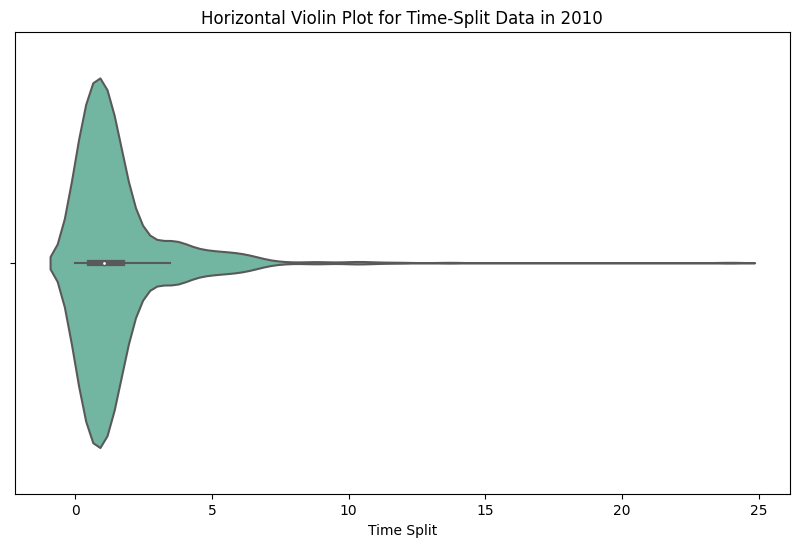

In [ ]:
plot_time_split_violin(quali,2016)

In [ ]:
# Melt the DataFrame to stack the split times
melted_df = pd.melt(quali, id_vars=['raceId', 'driverId', 'year'],
                    value_vars=['time-split-q1', 'time-split-q2', 'time-split-q3'],
                    var_name='split_type', value_name='split_time')

melted_df.tail(20)

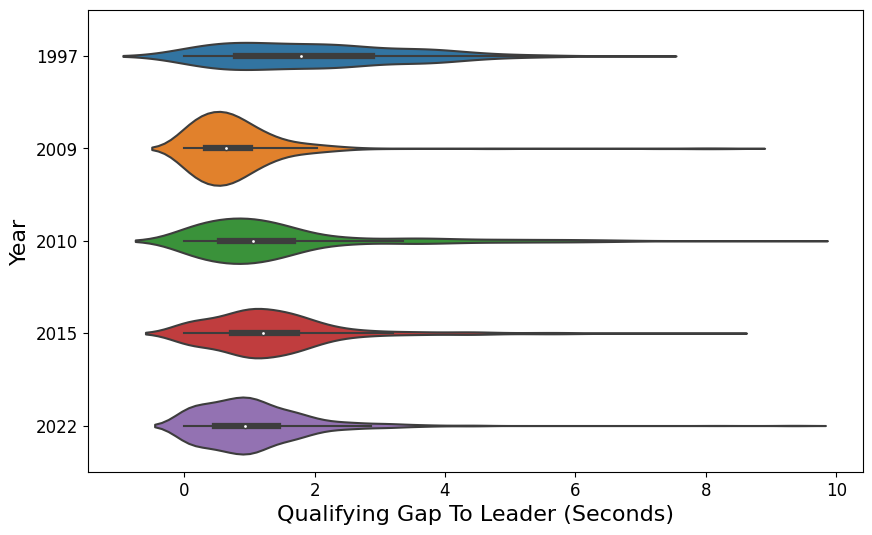

In [ ]:
# Create a horizontal violin plot
# List of specified years
specified_years = [1997,2009,2010,2015,2022]  # Add your desired years to this list

# Filter the DataFrame for the specified years
filtered_df = melted_df[melted_df['year'].isin(specified_years)]
filtered_df = filtered_df[filtered_df['split_time'] <= 10]
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.violinplot(x='split_time', y='year', data=filtered_df, orient='h')
plt.xticks(fontsize=12)  # Adjust the font size as needed
plt.yticks(fontsize=12)  # Adjust the font size as needed
plt.xlabel('Qualifying Gap To Leader (Seconds)',fontsize=16)
plt.ylabel('Year',fontsize=16)
plt.show()

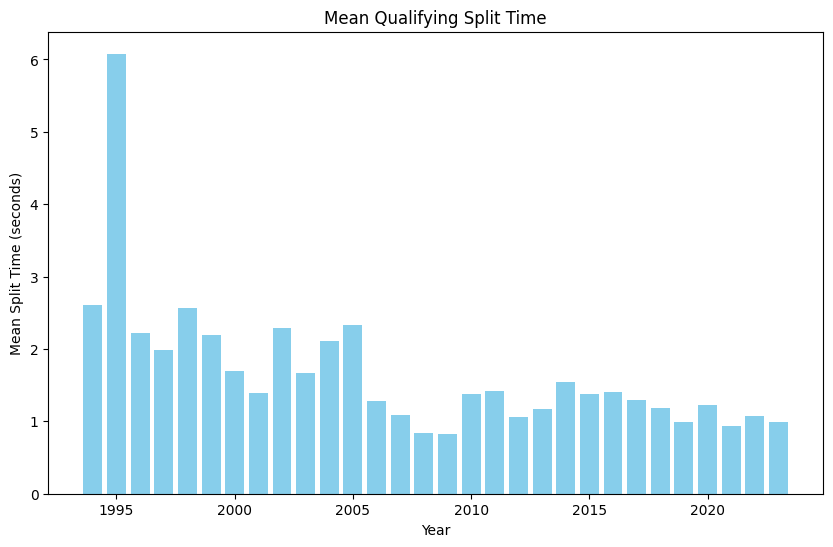

In [ ]:
def plot_mean_split_time_bar_graph(df):
    # Extract the time-split columns
    time_split_columns = ['time-split-q1', 'time-split-q2', 'time-split-q3']

    # Create an empty DataFrame to store the mean split time for each year
    mean_split_time_df = df.groupby('year')[time_split_columns].mean()

    # Calculate the mean split time for combined data for each year
    mean_split_time_df['mean_split_time_combined'] = mean_split_time_df.mean(axis=1)

    # Create a bar graph
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    plt.bar(mean_split_time_df.index, mean_split_time_df['mean_split_time_combined'], color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Mean Split Time (seconds)')
    plt.title('Mean Qualifying Split Time')

    plt.show()


plot_mean_split_time_bar_graph(quali)